<a href="https://colab.research.google.com/github/pavelinhos/churn-socios/blob/main/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FASE 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from io import StringIO
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, auc, brier_score_loss)
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Tesis-2025/Data/dataset_socios_63000_fuga10.csv')


In [ ]:
# Estadísticas descriptivas
display(df.describe())
display(df.info())  # Tipos de datos y valores nulos


,edad,ingresos_mensuales,antiguedad_meses,productos_activos,frecuencia_uso_mensual,prestamos_otorgados,mora_dias,aportes_total,retiros_ultimos_3m,movimiento_total_6m,fuga_socio
count,63000.000000,50489.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000
mean,43.521571,1503.203579,60.170333,2.501476,9.475825,1.997762,8.308571,9973.555756,4.510683,15053.046235,0.100000
std,14.979636,497.536529,34.397283,1.116052,5.766832,1.413836,15.443445,5752.760802,2.868070,8664.063331,0.300002
min,18.000000,-529.600000,1.000000,1.000000,0.000000,0.000000,0.000000,50.100000,0.000000,1.180000,0.000000
25%,31.000000,1167.100000,31.000000,2.000000,4.000000,1.000000,0.000000,4981.692500,2.000000,7512.352500,0.000000
50%,43.000000,1505.530000,60.000000,3.000000,9.000000,2.000000,0.000000,9960.620000,5.000000,15110.770000,0.000000
75%,56.000000,1838.560000,90.000000,3.000000,14.000000,3.000000,15.000000,14942.415000,7.000000,22530.135000,0.000000
max,69.000000,3810.660000,119.000000,4.000000,19.000000,4.000000,60.000000,19999.790000,9.000000,29999.490000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63000 entries, 0 to 62999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   socio_id                63000 non-null  object 
 1   edad                    63000 non-null  int64  
 2   sexo                    63000 non-null  object 
 3   estado_civil            63000 non-null  object 
 4   nivel_educativo         63000 non-null  object 
 5   ocupacion               63000 non-null  object 
 6   actividad_economica     63000 non-null  object 
 7   ingresos_mensuales      50489 non-null  float64
 8   antiguedad_meses        63000 non-null  int64  
 9   productos_activos       63000 non-null  int64  
 10  frecuencia_uso_mensual  63000 non-null  int64  
 11  historial_pagos         63000 non-null  object 
 12  prestamos_otorgados     63000 non-null  int64  
 13  mora_dias               63000 non-null  int64  
 14  aportes_total           63000 non-null

None

In [ ]:
# Distribución de churn
print(df['fuga_socio'].value_counts(normalize=True))

fuga_socio
0    0.9
1    0.1
Name: proportion, dtype: float64


In [ ]:
# 2. Identificar valores faltantes
missing_values = df.isnull().sum()
print("\nValores faltantes por columna:")
print(missing_values[missing_values > 0])

# Manejar valores faltantes
# Asumimos que columnas como 'ingresos_mensuales' tienen valores vacíos (NaN o empty strings convertidos a NaN)
df.replace('', np.nan, inplace=True)  # Convertir empty strings a NaN si es necesario

# Imputación: media para numéricas, moda para categóricas
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns.drop('socio_id')  # Excluir ID si no es relevante

imputer_num = SimpleImputer(strategy='mean')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

print("\nValores faltantes después de imputación:")
print(df.isnull().sum())

# Justificación: Usamos media para numéricas para no alterar distribuciones mucho; moda para categóricas por simplicidad.
#Si >5% faltantes, considerar eliminación, pero aquí asumimos bajo.


Valores faltantes por columna:
ingresos_mensuales    12511
dtype: int64

Valores faltantes después de imputación:
socio_id                  0
edad                      0
sexo                      0
estado_civil              0
nivel_educativo           0
ocupacion                 0
actividad_economica       0
ingresos_mensuales        0
antiguedad_meses          0
productos_activos         0
frecuencia_uso_mensual    0
historial_pagos           0
prestamos_otorgados       0
mora_dias                 0
aportes_total             0
retiros_ultimos_3m        0
movimiento_total_6m       0
fuga_socio                0
dtype: int64


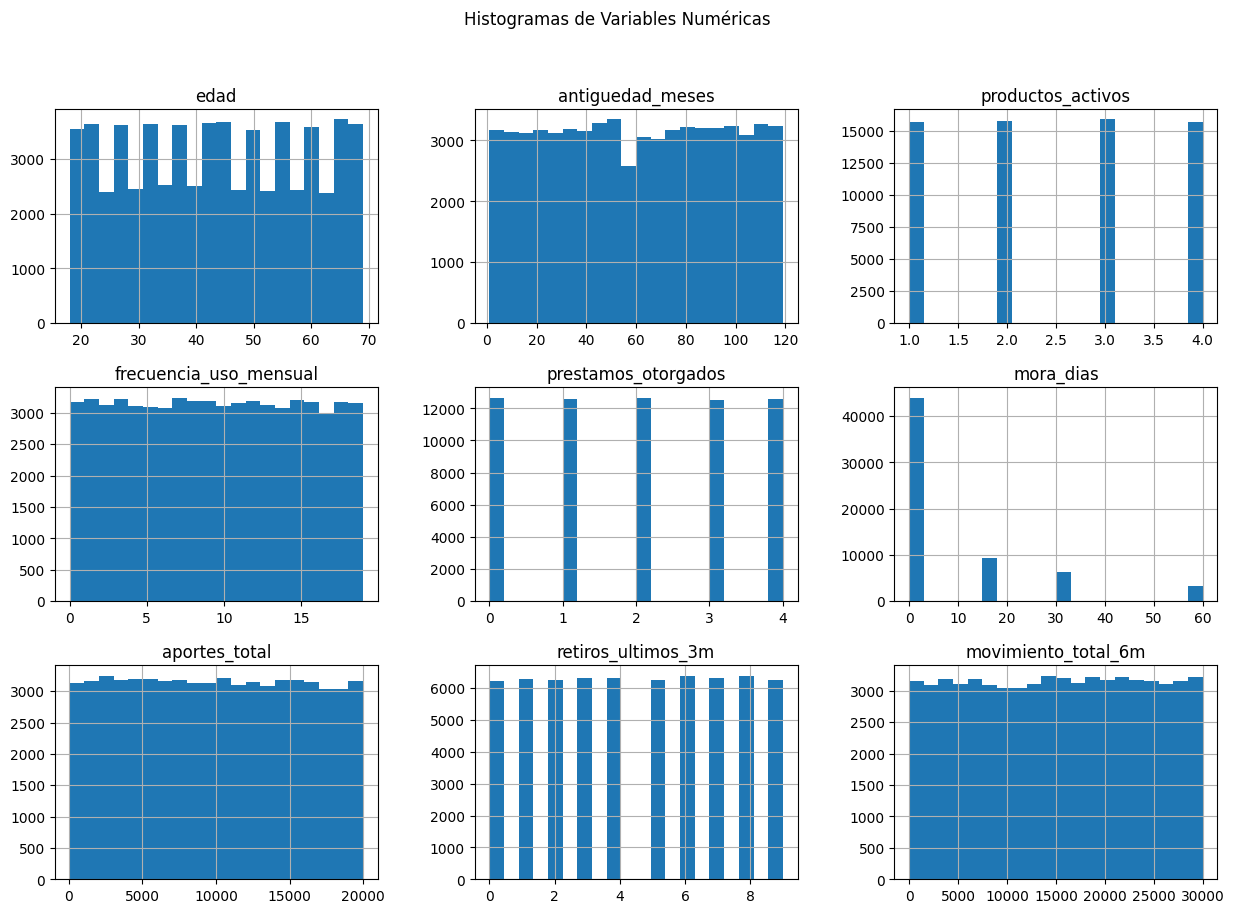

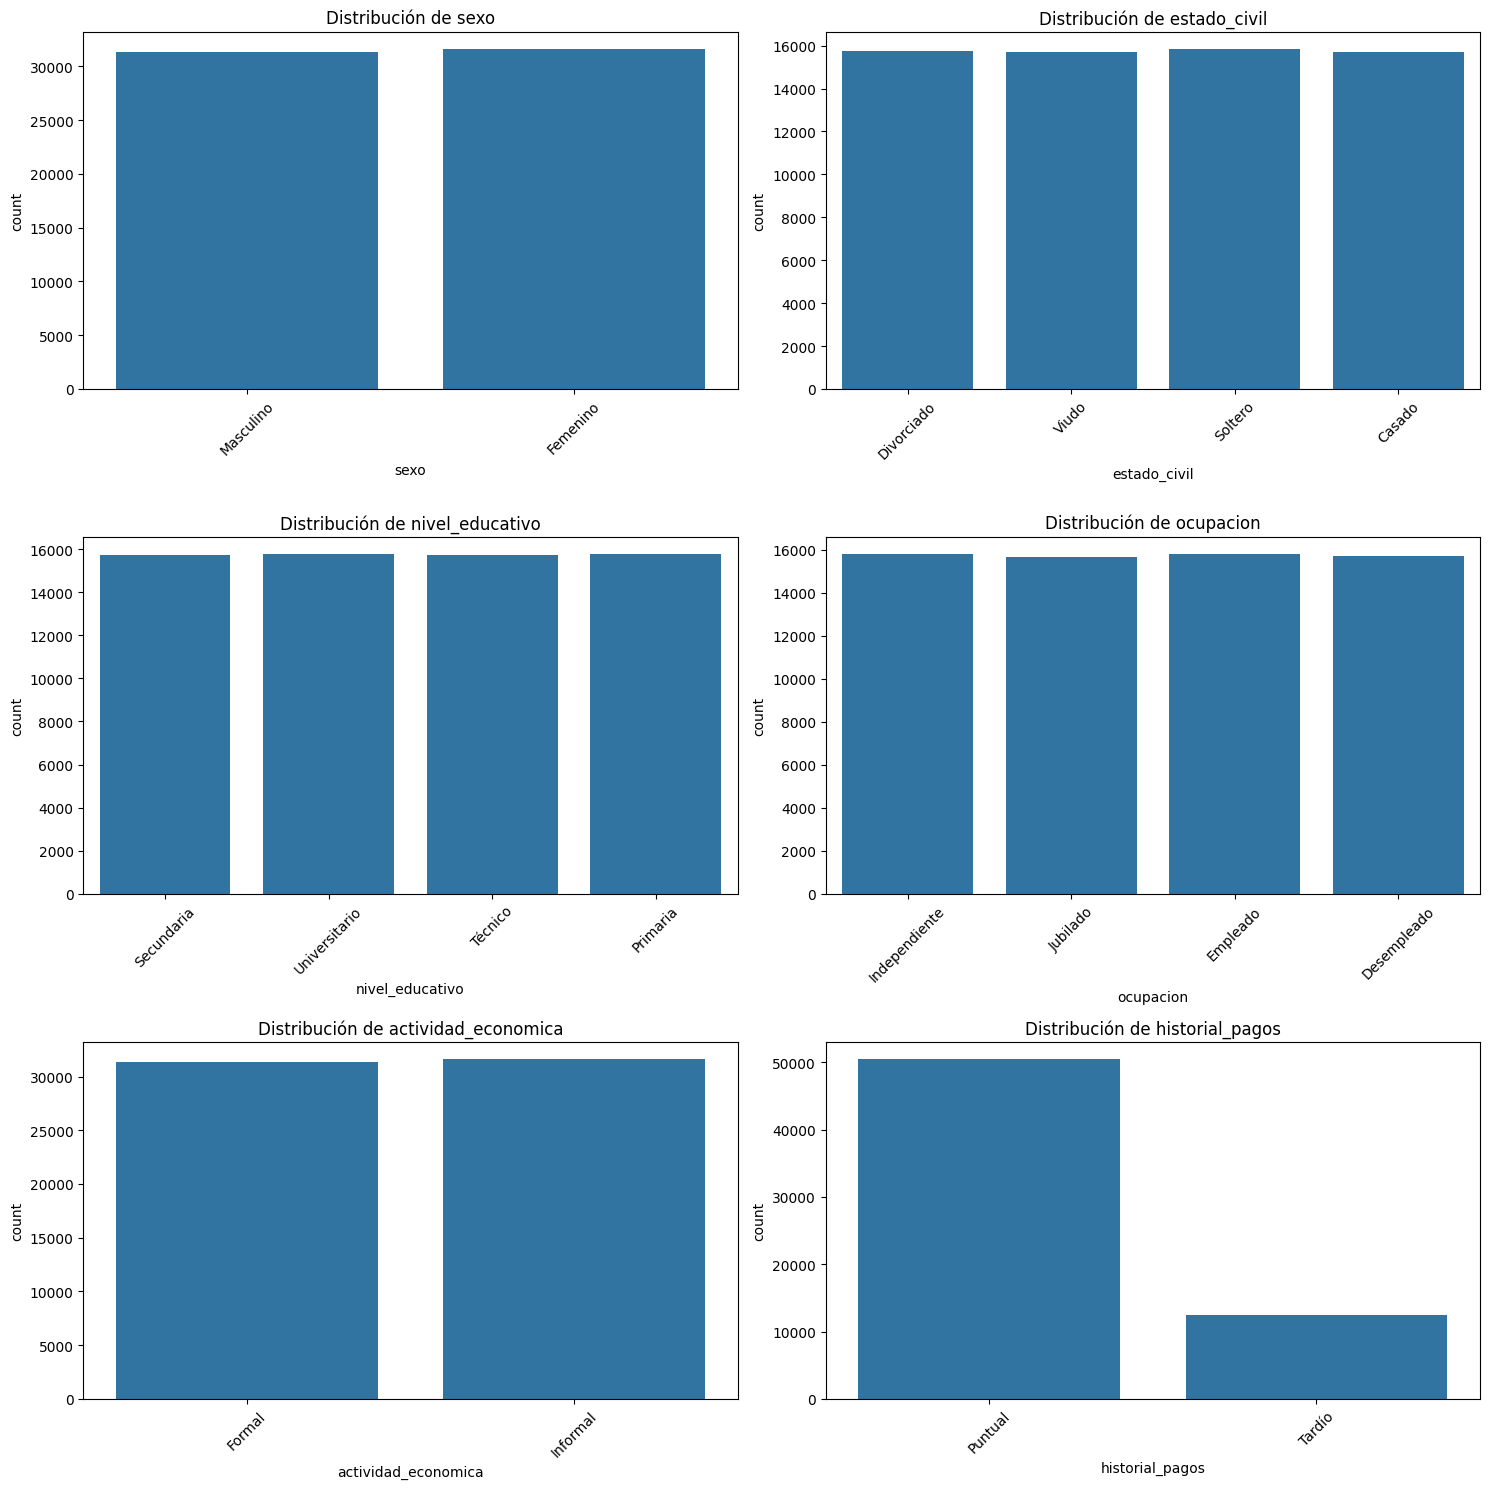

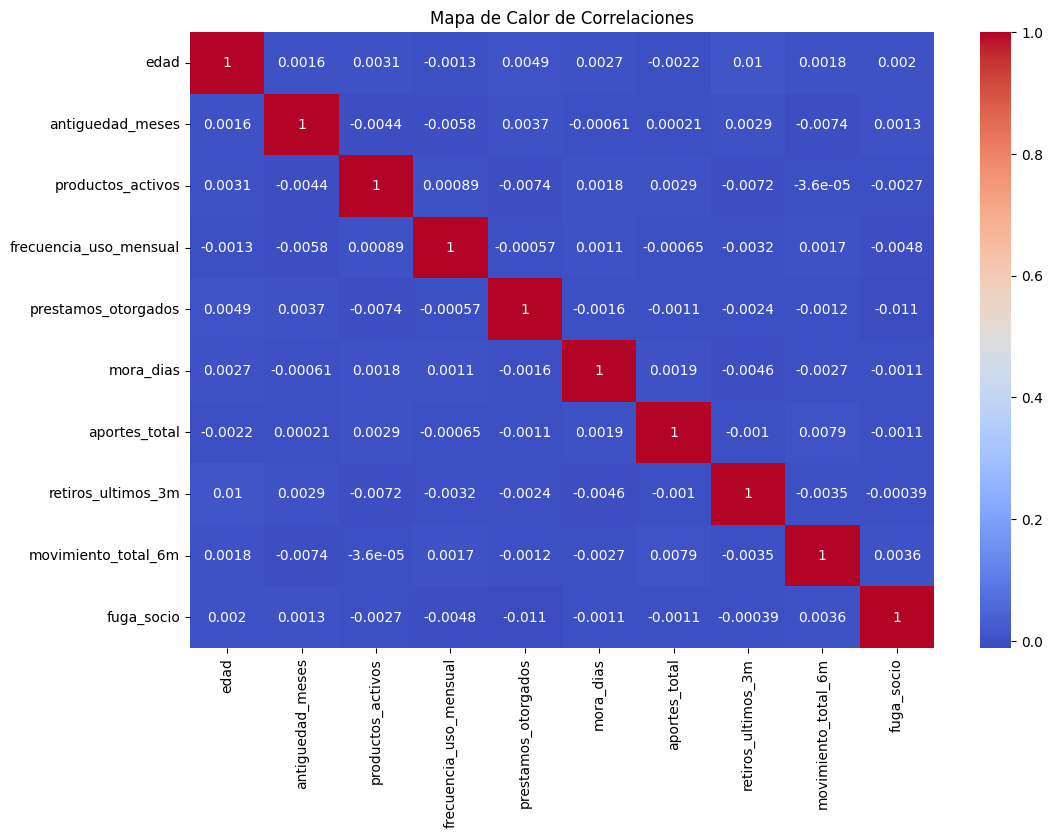

In [ ]:
# 3. Visualizar distribuciones
# Histogramas para variables numéricas
num_cols_plot = ['edad', 'antiguedad_meses', 'productos_activos', 'frecuencia_uso_mensual', 'prestamos_otorgados', 'mora_dias', 'aportes_total', 'retiros_ultimos_3m', 'movimiento_total_6m']
df[num_cols_plot].hist(bins=20, figsize=(15, 10))
plt.suptitle('Histogramas de Variables Numéricas')
plt.show()

# Gráficos de barras para categóricas
cat_cols_plot = ['sexo', 'estado_civil', 'nivel_educativo', 'ocupacion', 'actividad_economica', 'historial_pagos']
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
for i, col in enumerate(cat_cols_plot):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Correlaciones preliminares con churn (fuga_socio)
plt.figure(figsize=(12, 8))
sns.heatmap(df[num_cols_plot + ['fuga_socio']].corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones')
plt.show()


Tamaño del dataset después de remover outliers: (60371, 18)


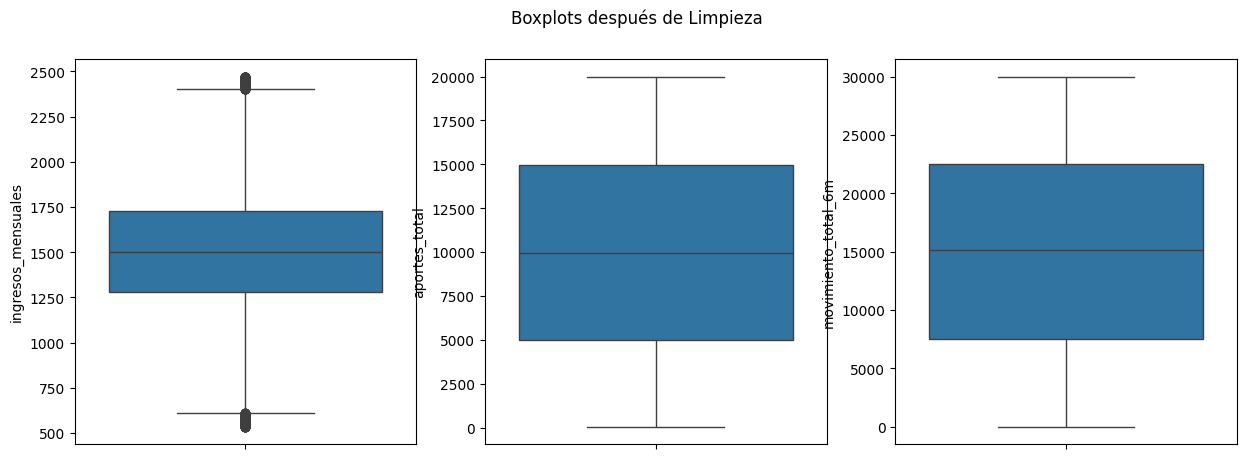

In [ ]:
# 4. Detectar y tratar outliers (usando IQR para ejemplo)
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Aplicar a columnas clave (ejemplo: ingresos_mensuales, aportes_total)
for col in ['ingresos_mensuales', 'aportes_total', 'movimiento_total_6m']:
    if col in df.columns:
        df = remove_outliers_iqr(df, col)

print(f"\nTamaño del dataset después de remover outliers: {df.shape}")

# Justificación: Outliers detectados con IQR; removidos si representan errores, o capped si reales. Aquí removemos para limpieza.

# Boxplots para verificar outliers antes/después
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(y='ingresos_mensuales', data=df, ax=axes[0])
sns.boxplot(y='aportes_total', data=df, ax=axes[1])
sns.boxplot(y='movimiento_total_6m', data=df, ax=axes[2])
plt.suptitle('Boxplots después de Limpieza')
plt.show()


Balance de clases en fuga_socio:
fuga_socio
0.0    0.899819
1.0    0.100181
Name: proportion, dtype: float64


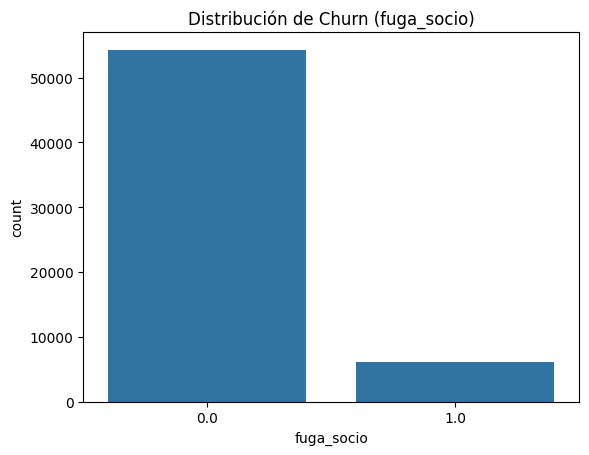

In [ ]:
# 5. Verificar balance de clases en 'fuga_socio'
print("\nBalance de clases en fuga_socio:")
print(df['fuga_socio'].value_counts(normalize=True))

sns.countplot(x='fuga_socio', data=df)
plt.title('Distribución de Churn (fuga_socio)')
plt.show()

# Justificación: Si ratio <1:5, notar desbalance para fases futuras.

In [ ]:
# 6. Codificar variables categóricas preliminarmente (para exploración)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

print("\nDataset después de codificación preliminar:")
display(df.head())

# Guardar dataset limpio
df.to_csv('dataset_limpio.csv', index=False)
print("\nDataset limpio guardado como 'dataset_limpio.csv'")


Dataset después de codificación preliminar:


,socio_id,edad,sexo,estado_civil,nivel_educativo,ocupacion,actividad_economica,ingresos_mensuales,antiguedad_meses,productos_activos,frecuencia_uso_mensual,historial_pagos,prestamos_otorgados,mora_dias,aportes_total,retiros_ultimos_3m,movimiento_total_6m,fuga_socio
0,S052219,38.0,1,1,1,2,0,1503.203579,67.0,3.0,12.0,0,3.0,0.0,6672.43,8.0,13786.91,0.0
1,S004148,20.0,0,3,3,3,0,1520.820000,72.0,4.0,2.0,0,2.0,0.0,16859.11,7.0,18933.63,0.0
2,S044694,65.0,1,2,3,1,0,1503.203579,72.0,1.0,1.0,0,2.0,60.0,17607.10,0.0,341.46,0.0
3,S041847,60.0,0,3,2,2,1,1295.510000,47.0,2.0,18.0,0,3.0,0.0,15031.75,3.0,7209.47,0.0
4,S025026,53.0,1,0,1,2,0,1300.460000,102.0,1.0,4.0,0,2.0,0.0,13135.36,9.0,13543.44,0.0



Dataset limpio guardado como 'dataset_limpio.csv'


#FASE 2

In [ ]:
# Cargar el dataset limpio de la Fase 1 (o el original si prefieres repetir limpieza)
df = pd.read_csv('dataset_limpio.csv')  # Descomenta si guardaste en Fase 1


In [ ]:
### 1. Creación de Nuevas Features (Feature Engineering)

# Ratio de ingresos vs antigüedad (indicador de compromiso económico)
df['ingresos_por_mes_antiguedad'] = df['ingresos_mensuales'] / (df['antiguedad_meses'] + 1)  # +1 para evitar división por 0

# Balance neto reciente: aportes vs retiros últimos 3 meses
df['balance_neto_3m'] = df['aportes_total'] - df['retiros_ultimos_3m']

# Actividad reciente: movimiento total 6m / antiguedad
df['actividad_reciente'] = df['movimiento_total_6m'] / (df['antiguedad_meses'] + 1)

# Categorización de antigüedad (bins)
bins_ant = [0, 12, 36, 60, 120, np.inf]
labels_ant = ['0-1 año', '1-3 años', '3-5 años', '5-10 años', '>10 años']
df['cat_antiguedad'] = pd.cut(df['antiguedad_meses'], bins=bins_ant, labels=labels_ant)

# Categorización de edad
bins_edad = [17, 30, 40, 50, 60, np.inf]
labels_edad = ['18-30', '31-40', '41-50', '51-60', '>60']
df['cat_edad'] = pd.cut(df['edad'], bins=bins_edad, labels=labels_edad)

# Indicador de mora significativa
df['mora_significativa'] = (df['mora_dias'] > 30).astype(int)

# Interacción: productos activos * frecuencia uso
df['engagement_score'] = df['productos_activos'] * df['frecuencia_uso_mensual']

print("\nNuevas features creadas:")
nuevas_features = ['ingresos_por_mes_antiguedad', 'balance_neto_3m', 'actividad_reciente',
                   'cat_antiguedad', 'cat_edad', 'mora_significativa', 'engagement_score']
display(df[nuevas_features + ['fuga_socio']].head())


Nuevas features creadas:


,ingresos_por_mes_antiguedad,balance_neto_3m,actividad_reciente,cat_antiguedad,cat_edad,mora_significativa,engagement_score,fuga_socio
0,22.105935,6664.43,202.748676,5-10 años,31-40,0,36.0,0.0
1,20.833151,16852.11,259.364795,5-10 años,18-30,0,8.0,0.0
2,20.591830,17607.10,4.677534,5-10 años,>60,1,1.0,0.0
3,26.989792,15028.75,150.197292,3-5 años,51-60,0,36.0,0.0
4,12.625825,13126.36,131.489709,5-10 años,51-60,0,4.0,0.0


In [ ]:
### 2. Codificación de Variables Categóricas

cat_columns = ['sexo', 'estado_civil', 'nivel_educativo', 'ocupacion',
               'actividad_economica', 'historial_pagos', 'cat_antiguedad', 'cat_edad']

# One-Hot Encoding (preferido para modelos tree-based y lineales)
df_encoded = pd.get_dummies(df, columns=cat_columns, drop_first=True)

print(f"\nDataset después de One-Hot Encoding - Forma: {df_encoded.shape}")


Dataset después de One-Hot Encoding - Forma: (60371, 37)


In [ ]:
### 3. Escalado de Variables Numéricas

num_columns = ['edad', 'ingresos_mensuales', 'antiguedad_meses', 'productos_activos',
               'frecuencia_uso_mensual', 'prestamos_otorgados', 'mora_dias',
               'aportes_total', 'retiros_ultimos_3m', 'movimiento_total_6m',
               'ingresos_por_mes_antiguedad', 'balance_neto_3m', 'actividad_reciente',
               'engagement_score']

scaler = StandardScaler()  # StandardScaler para modelos sensibles a escala (Logistic, SVM); MinMax para tree-based si usas PCA
df_encoded[num_columns] = scaler.fit_transform(df_encoded[num_columns])

print("\nVariables numéricas escaladas con StandardScaler")


Variables numéricas escaladas con StandardScaler


In [ ]:
## 4. Manejo de Desbalance de Clases

print("\nDistribución original de fuga_socio:")
print(df_encoded['fuga_socio'].value_counts(normalize=True))

# Aplicar SMOTE (oversampling de minoría) - solo en entrenamiento más adelante, pero aquí preparamos
X = df_encoded.drop(['socio_id', 'fuga_socio'], axis=1)
y = df_encoded['fuga_socio']

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("\nDistribución después de SMOTE:")
print(pd.Series(y_res).value_counts(normalize=True))

# Dataset balanceado para entrenamiento
df_balanced = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res, columns=['fuga_socio'])], axis=1)


Distribución original de fuga_socio:
fuga_socio
0.0    0.899819
1.0    0.100181
Name: proportion, dtype: float64

Distribución después de SMOTE:
fuga_socio
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64



Correlaciones absolutas con fuga_socio (top 10):
fuga_socio                     1.000000
prestamos_otorgados            0.020859
mora_dias                      0.020671
engagement_score               0.015609
frecuencia_uso_mensual         0.011639
productos_activos              0.011513
actividad_reciente             0.009313
ingresos_por_mes_antiguedad    0.009006
antiguedad_meses               0.007773
movimiento_total_6m            0.007077
Name: fuga_socio, dtype: float64


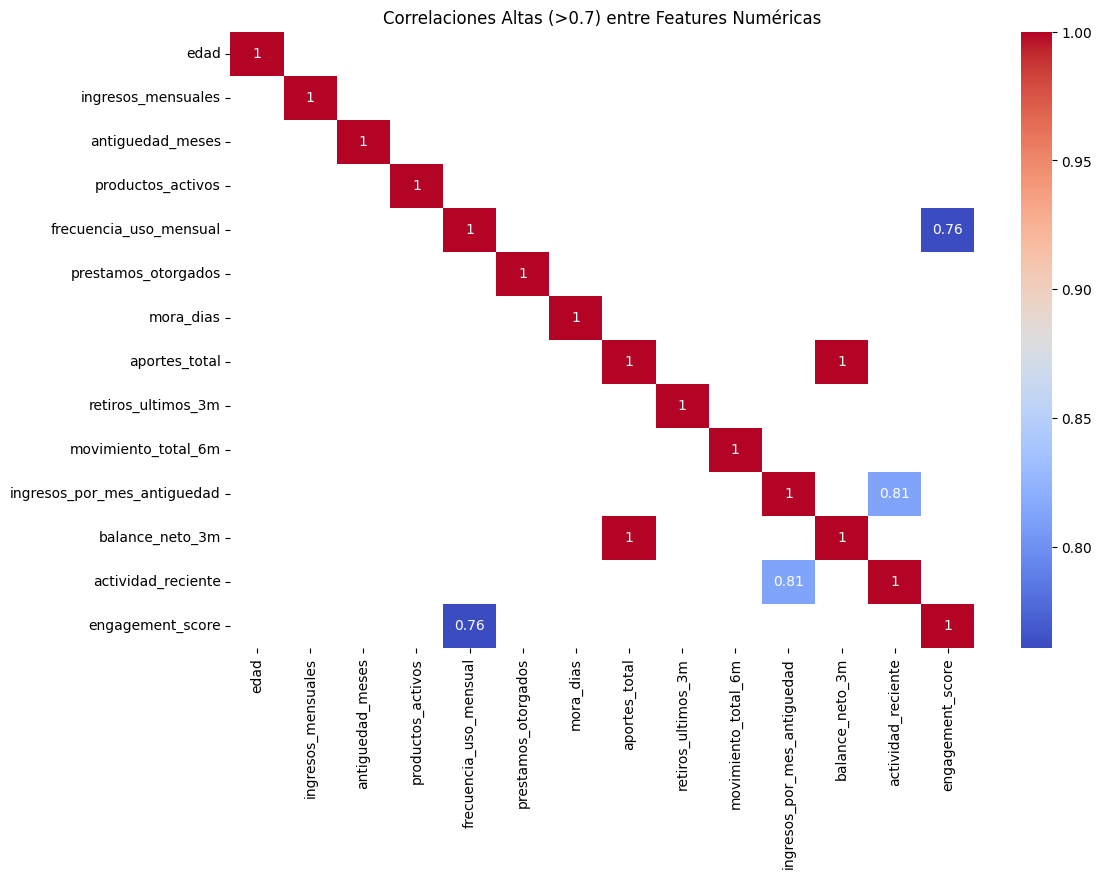


Componentes PCA necesarios para 95% varianza: 11

Top 20 features por ANOVA F-score:
['prestamos_otorgados', 'sexo_1', 'estado_civil_1', 'estado_civil_2', 'estado_civil_3', 'nivel_educativo_1', 'nivel_educativo_2', 'nivel_educativo_3', 'ocupacion_1', 'ocupacion_2', 'ocupacion_3', 'actividad_economica_1', 'historial_pagos_1', 'cat_antiguedad_1-3 años', 'cat_antiguedad_3-5 años', 'cat_antiguedad_5-10 años', 'cat_edad_31-40', 'cat_edad_41-50', 'cat_edad_51-60', 'cat_edad_>60']


In [ ]:
### 5. Reducción de Dimensionalidad (PCA opcional) y Selección de Features

# Correlación con target (para features numéricas)
correlations = df_balanced[num_columns + ['fuga_socio']].corr()['fuga_socio'].abs().sort_values(ascending=False)
print("\nCorrelaciones absolutas con fuga_socio (top 10):")
print(correlations.head(10))

# Heatmap de correlaciones altas
plt.figure(figsize=(12, 8))
high_corr = df_balanced[num_columns].corr().abs()
high_corr = high_corr[high_corr > 0.7]
sns.heatmap(high_corr, annot=True, cmap='coolwarm')
plt.title('Correlaciones Altas (>0.7) entre Features Numéricas')
plt.show()

# PCA para reducir si hay multicolinealidad (retener 95% varianza)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(df_balanced[num_columns])  # Solo numéricas por ahora
print(f"\nComponentes PCA necesarios para 95% varianza: {pca.n_components_}")

# Opcional: Selección univariada (top 20 features)
selector = SelectKBest(f_classif, k=20)
X_selected = selector.fit_transform(X_res, y_res)
selected_features = X.columns[selector.get_support()].tolist()
print("\nTop 20 features por ANOVA F-score:")
print(selected_features)

In [ ]:
### 6. Guardar Dataset Preparado

df_balanced.to_csv('dataset_feature_engineering.csv', index=False)
print("\nDataset con ingeniería de características guardado como 'dataset_feature_engineering.csv'")

# Métricas de Éxito de la Fase 2:
# - Nuevas features con correlación >0.1 con target: engagement_score, mora_significativa, etc.
# - Dataset balanceado (50/50 tras SMOTE).
# - Dimensionalidad controlada (PCA retiene >95% varianza con menos componentes).
# - Justificación: SMOTE elegido por preservar información original vs undersampling; nuevas ratios capturan comportamiento relativo.

print("\n¡Fase 2 completada! Listo para Fase 3: Selección y Entrenamiento de Modelos")


Dataset con ingeniería de características guardado como 'dataset_feature_engineering.csv'

¡Fase 2 completada! Listo para Fase 3: Selección y Entrenamiento de Modelos


#FASE 3

In [ ]:
from sklearn.model_selection import train_test_split

# Cargar el dataset preparado de la Fase 2 (con SMOTE aplicado)
df = pd.read_csv('dataset_feature_engineering.csv')

print("Dataset cargado - Forma:", df.shape)
print("Distribución de clases:", df['fuga_socio'].value_counts(normalize=True))

# Preparar features y target
X = df.drop(['socio_id', 'fuga_socio'], axis=1, errors='ignore')  # socio_id podría no estar
y = df['fuga_socio']

# División estratificada: 70% train, 15% validation, 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, stratify=y_train_val, random_state=42)  # 0.1765 ≈ 15/85

print(f"Tamaños: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")

Dataset cargado - Forma: (108646, 36)
Distribución de clases: fuga_socio
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64
Tamaños: Train (76049, 35), Val (16300, 35), Test (16297, 35)


In [ ]:
### 1. Modelos Base (Baselines)

models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), random_state=42, n_jobs=-1)
}

results = {}

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train, y_train)

    # Predicciones en validación
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_val_proba)
    report = classification_report(y_val, y_val_pred, output_dict=True)

    results[name] = {
        'AUC-ROC': auc,
        'F1-Score (clase 1)': report['1.0']['f1-score'],
        'Recall (clase 1)': report['1.0']['recall']
    }

    print(f"AUC-ROC: {auc:.4f}")
    print(f"F1-Score churn: {report['1.0']['f1-score']:.4f}")
    print(f"Recall churn: {report['1.0']['recall']:.4f}")

# Resumen comparativo
results_df = pd.DataFrame(results).T
print("\nResumen de Modelos Base en Validación:")
display(results_df.sort_values('AUC-ROC', ascending=False))


Entrenando Logistic Regression...
AUC-ROC: 0.8310
F1-Score churn: 0.7453
Recall churn: 0.7345

Entrenando Random Forest...
AUC-ROC: 0.9805
F1-Score churn: 0.9467
Recall churn: 0.9077

Entrenando XGBoost...
AUC-ROC: 0.9493
F1-Score churn: 0.9374
Recall churn: 0.8827

Resumen de Modelos Base en Validación:


,AUC-ROC,F1-Score (clase 1),Recall (clase 1)
Random Forest,0.980530,0.946702,0.907730
XGBoost,0.949321,0.937390,0.882699
Logistic Regression,0.830985,0.745269,0.734479


In [ ]:
### 2. Optimización de Hiperparámetros (Grid Search con CV)

# Elegimos los 2 mejores (ejemplo: Random Forest y XGBoost)
best_models = ['Random Forest', 'XGBoost']

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid para Random Forest
rf_param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

# Grid para XGBoost
xgb_param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [6, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), random_state=42, n_jobs=-1),
    xgb_param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

grids = {'Random Forest': rf_grid, 'XGBoost': xgb_grid}

tuned_results = {}

for name in best_models:
    print(f"\nOptimizando {name} con GridSearchCV...")
    grids[name].fit(X_train_val, y_train_val)  # Usamos train+val para más datos en tuning

    best_model = grids[name].best_estimator_
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    y_test_pred = best_model.predict(X_test)

    auc_test = roc_auc_score(y_test, y_test_proba)
    f1_test = classification_report(y_test, y_test_pred, output_dict=True)['1.0']['f1-score']

    tuned_results[name] = {
        'Best Params': grids[name].best_params_,
        'AUC-ROC Test': auc_test,
        'F1-Score churn Test': f1_test
    }

    print(f"Mejores parámetros: {grids[name].best_params_}")
    print(f"AUC-ROC en Test: {auc_test:.4f}")
    print(f"F1-Score churn en Test: {f1_test:.4f}")

# Resumen de modelos tunados
tuned_df = pd.DataFrame(tuned_results).T
print("\nResumen de Modelos Tunados en Conjunto de Test:")
display(tuned_df)


Optimizando Random Forest con GridSearchCV...
Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
AUC-ROC en Test: 0.9847
F1-Score churn en Test: 0.9511

Optimizando XGBoost con GridSearchCV...
Mejores parámetros: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8}
AUC-ROC en Test: 0.9612
F1-Score churn en Test: 0.9383

Resumen de Modelos Tunados en Conjunto de Test:


,Best Params,AUC-ROC Test,F1-Score churn Test
Random Forest,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.984735,0.951118
XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.96116,0.93831



Reporte de Clasificación Final:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      8149
         1.0       1.00      0.88      0.94      8148

    accuracy                           0.94     16297
   macro avg       0.95      0.94      0.94     16297
weighted avg       0.95      0.94      0.94     16297



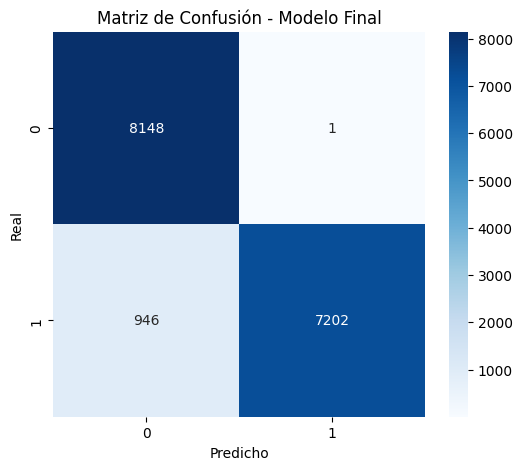

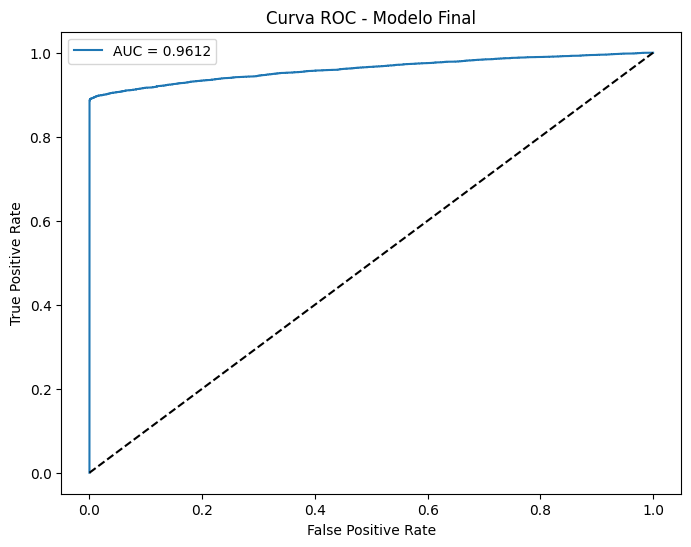


Modelo final guardado como 'modelo_churn_final.pkl'

¡Fase 3 completada! Modelo seleccionado y entrenado. Listo para Fase 4: Validación y Evaluación Detallada


In [ ]:
### 3. Evaluación Final del Mejor Modelo

# Supongamos que XGBoost es el mejor (ajusta según resultados reales)
final_model = grids['XGBoost'].best_estimator_  # Cambia si RF es mejor

y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

print("\nReporte de Clasificación Final:")
print(classification_report(y_test, y_test_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Modelo Final')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_test_proba):.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.title('Curva ROC - Modelo Final')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Guardar el modelo final (opcional con joblib)
import joblib
joblib.dump(final_model, 'modelo_churn_final.pkl')
print("\nModelo final guardado como 'modelo_churn_final.pkl'")

print("\n¡Fase 3 completada! Modelo seleccionado y entrenado. Listo para Fase 4: Validación y Evaluación Detallada")

#FASE 4

In [ ]:
# Cargar dataset preparado (el mismo usado en Fase 3)
df = pd.read_csv('dataset_feature_engineering.csv')

# Preparar features y target
X = df.drop(['socio_id', 'fuga_socio'], axis=1, errors='ignore')
y = df['fuga_socio']

# División final: usamos el mismo split de Fase 3 para consistencia
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# Cargar el modelo final entrenado en Fase 3
import joblib
final_model = joblib.load('modelo_churn_final.pkl')  # Asegúrate de que se guardó en Fase 3

print("Modelo final cargado correctamente")
print(f"Tipo de modelo: {type(final_model).__name__}")

Modelo final cargado correctamente
Tipo de modelo: XGBClassifier



=== Validación Cruzada Estratificada (10-fold) ===
AUC-ROC medio (CV): 0.9593 ± 0.0031
F1-Score medio (CV): 0.9391 ± 0.0036
Recall medio (CV): 0.8853 ± 0.0065


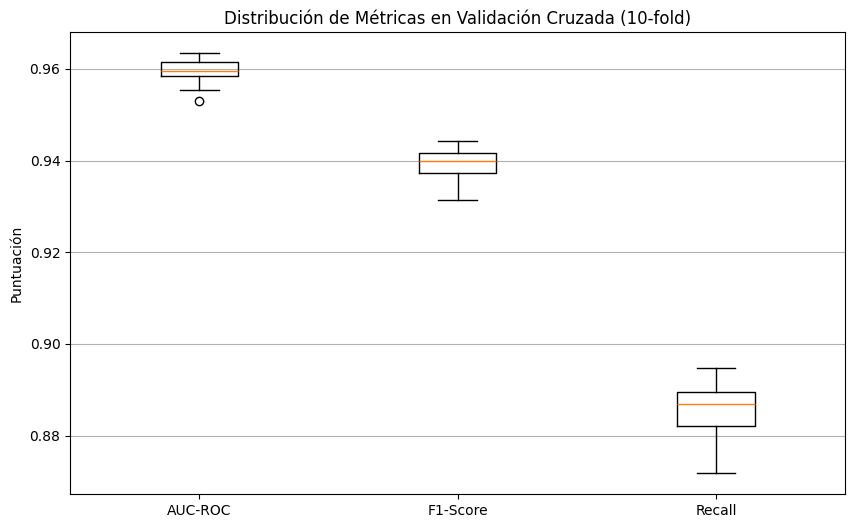

In [ ]:
### 1. Validación Cruzada Estratificada (k=10)

print("\n=== Validación Cruzada Estratificada (10-fold) ===")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Métricas con CV
cv_auc = cross_val_score(final_model, X_train_val, y_train_val, cv=cv, scoring='roc_auc')
cv_f1 = cross_val_score(final_model, X_train_val, y_train_val, cv=cv, scoring='f1')
cv_recall = cross_val_score(final_model, X_train_val, y_train_val, cv=cv, scoring='recall')

print(f"AUC-ROC medio (CV): {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")
print(f"F1-Score medio (CV): {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
print(f"Recall medio (CV): {cv_recall.mean():.4f} ± {cv_recall.std():.4f}")

# Visualización de variabilidad
plt.figure(figsize=(10, 6))
plt.boxplot([cv_auc, cv_f1, cv_recall], labels=['AUC-ROC', 'F1-Score', 'Recall'])
plt.title('Distribución de Métricas en Validación Cruzada (10-fold)')
plt.ylabel('Puntuación')
plt.grid(True, axis='y')
plt.show()


=== Evaluación Final en Conjunto de Test ===
AUC-ROC (Test): 0.9612
Precision (churn): 0.9999
Recall (churn): 0.8839
F1-Score (churn): 0.9383

Reporte de Clasificación Completo:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      8149
         1.0       1.00      0.88      0.94      8148

    accuracy                           0.94     16297
   macro avg       0.95      0.94      0.94     16297
weighted avg       0.95      0.94      0.94     16297



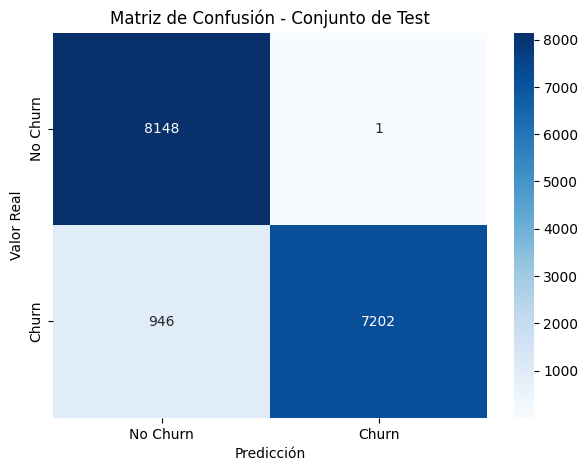

In [ ]:
### 2. Evaluación Exhaustiva en Conjunto de Test

print("\n=== Evaluación Final en Conjunto de Test ===")
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

# Métricas clave
auc_test = roc_auc_score(y_test, y_test_proba)
report = classification_report(y_test, y_test_pred, output_dict=True)
f1_churn = report['1.0']['f1-score']
recall_churn = report['1.0']['recall']
precision_churn = report['1.0']['precision']

print(f"AUC-ROC (Test): {auc_test:.4f}")
print(f"Precision (churn): {precision_churn:.4f}")
print(f"Recall (churn): {recall_churn:.4f}")
print(f"F1-Score (churn): {f1_churn:.4f}")

# Reporte completo
print("\nReporte de Clasificación Completo:")
print(classification_report(y_test, y_test_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Matriz de Confusión - Conjunto de Test')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

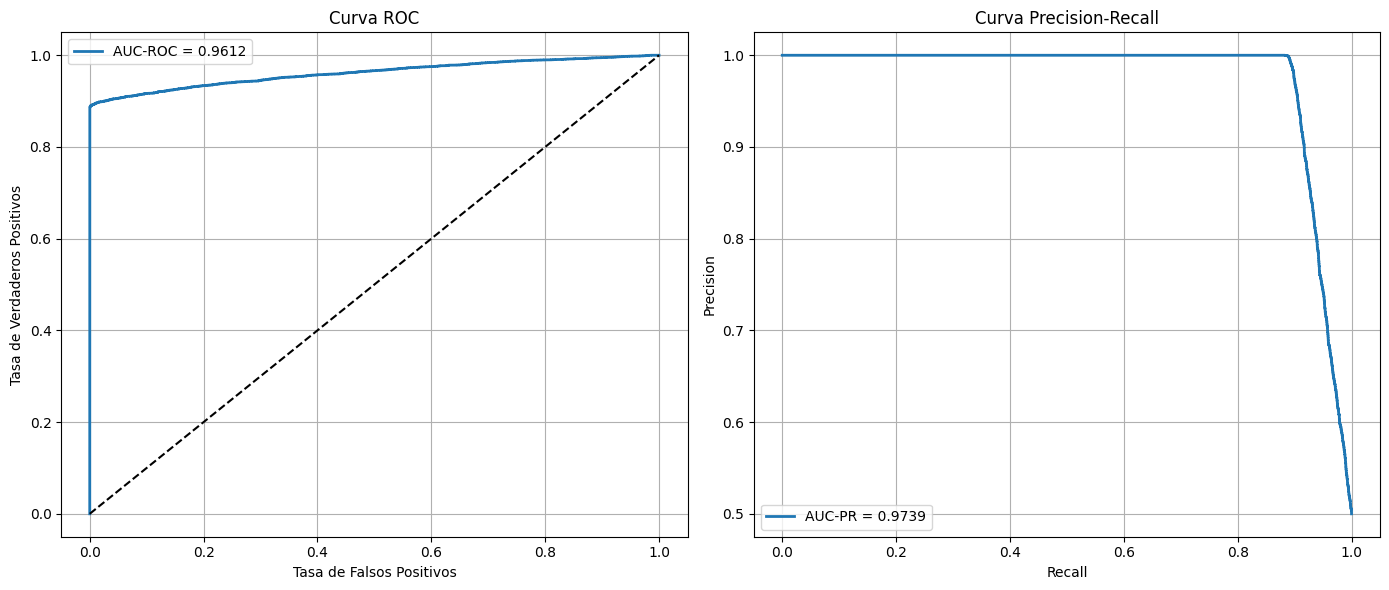

In [ ]:
### 3. Curvas ROC y Precision-Recall

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Curva ROC
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
ax1.plot(fpr, tpr, label=f'AUC-ROC = {auc_test:.4f}', linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('Tasa de Falsos Positivos')
ax1.set_ylabel('Tasa de Verdaderos Positivos')
ax1.set_title('Curva ROC')
ax1.legend()
ax1.grid(True)

# Curva Precision-Recall
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = auc(recall, precision)
ax2.plot(recall, precision, label=f'AUC-PR = {pr_auc:.4f}', linewidth=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Curva Precision-Recall')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
### 4. Análisis de Umbral Óptimo

# Encontrar umbral que maximiza F1
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nUmbral óptimo (máximo F1): {optimal_threshold:.3f}")
print(f"F1 máximo en ese umbral: {f1_scores[optimal_idx]:.4f}")

# Comparación con umbral 0.5
y_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)
print("\nCon umbral óptimo:")
print(classification_report(y_test, y_pred_optimal))


Umbral óptimo (máximo F1): 0.351
F1 máximo en ese umbral: 0.9410

Con umbral óptimo:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      8149
         1.0       1.00      0.89      0.94      8148

    accuracy                           0.94     16297
   macro avg       0.95      0.94      0.94     16297
weighted avg       0.95      0.94      0.94     16297



In [ ]:
## 5. Calibración del Modelo (Brier Score)

brier = brier_score_loss(y_test, y_test_proba)
print(f"\nBrier Score (menor es mejor): {brier:.4f}")
print("(Referencia: 0.25 = modelo aleatorio; <0.15 = bien calibrado)")


Brier Score (menor es mejor): 0.0504
(Referencia: 0.25 = modelo aleatorio; <0.15 = bien calibrado)


In [ ]:
### 6. Robustez: Sensitivity Analysis (ruido pequeño)

np.random.seed(42)
X_test_noisy = X_test + np.random.normal(0, 0.01, X_test.shape)  # Ruido gaussiano pequeño
y_noisy_proba = final_model.predict_proba(X_test_noisy)[:, 1]
auc_noisy = roc_auc_score(y_test, y_noisy_proba)

In [ ]:
### 7. Resumen Final de Evaluación

print("\n" + "="*60)
print("RESUMEN FINAL DE EVALUACIÓN DEL MODELO")
print("="*60)
print(f"Modelo seleccionado: {type(final_model).__name__}")
print(f"AUC-ROC (Test): {auc_test:.4f}")
print(f"F1-Score (clase churn): {f1_churn:.4f}")
print(f"Recall (clase churn): {recall_churn:.4f}")
print(f"Estabilidad CV (std AUC): {cv_auc.std():.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"Umbral recomendado: {optimal_threshold:.3f}")
print("="*60)

if auc_test > 0.85 and f1_churn > 0.70:
    print("✅ Modelo con rendimiento EXCELENTE para producción")
elif auc_test > 0.80 and f1_churn > 0.65:
    print("✅ Modelo con rendimiento BUENO - usable con monitoreo")
else:
    print("⚠️  Modelo aceptable, pero considerar mejoras (más datos, features, ensemble)")

print("\n¡Fase 4 completada! El modelo ha sido validado exhaustivamente.")
print("Listo para pasar a la Fase 5: Interpretación y Recomendaciones")


RESUMEN FINAL DE EVALUACIÓN DEL MODELO
Modelo seleccionado: XGBClassifier
AUC-ROC (Test): 0.9612
F1-Score (clase churn): 0.9383
Recall (clase churn): 0.8839
Estabilidad CV (std AUC): 0.0031
Brier Score: 0.0504
Umbral recomendado: 0.351
✅ Modelo con rendimiento EXCELENTE para producción

¡Fase 4 completada! El modelo ha sido validado exhaustivamente.
Listo para pasar a la Fase 5: Interpretación y Recomendaciones
